![Baseball Flights](baseball_flights.png)


To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling, and as such, we’ve got a few questions for you. 

Our primary areas of focus are surrounding the number of jets that The League needs to own, and the cost of fuel for those flights. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row, you’ll find information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but we're hoping you'll be able to project it to the future to help with the analysis.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

In [30]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
# Explore the data
team_flights = pd.read_csv('./team_flights.csv')
fuel_prices = pd.read_csv('./fuel_prices_2101.csv',
                         index_col='date')

team_flights.head()

# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

In [32]:
team_flights.sample(8)

,team_name,departure_datetime,landing_datetime,travel_distance_miles
971,Zealous Zebras,2102-06-26 21:21:00,2102-06-27 02:39:58,2658.055556
413,Knightly Kangaroos,2102-08-28 22:50:00,2102-08-29 00:03:11,609.861111
746,Tough Tigers,2102-07-10 22:09:00,2102-07-11 01:27:30,1654.166667
320,Ingenious Iguanas,2102-06-09 04:22:00,2102-06-09 05:29:14,560.277778
1086,Crazed Crocs,2102-06-19 22:41:00,2102-06-20 01:22:34,1346.388889
51,Brave Bears,2102-06-02 06:12:00,2102-06-02 08:06:56,957.777778
110,Cunning Cougars,2102-09-08 03:12:00,2102-09-08 05:35:46,1198.055556
904,Xenial Xerus,2102-08-04 20:29:00,2102-08-04 22:31:15,1018.750000


In [33]:
team_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   team_name              1145 non-null   object        
 1   departure_datetime     1145 non-null   datetime64[ns]
 2   landing_datetime       1145 non-null   datetime64[ns]
 3   travel_distance_miles  1145 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 35.9+ KB


In [34]:
fuel_prices.sample(5)

,price
date,
2101-04-26,1.08
2101-08-29,1.11
2101-06-27,1.04
2101-04-07,1.25
2101-02-03,1.19


In [35]:
fuel_prices.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 365 entries, 2101-01-01 to 2101-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


## **Question 1: Maximum number of jets needed**

**Breakdown:**

* Each team’s flight is defined by a `departure_datetime` and `landing_datetime`.
* A team is “in flight” during that interval.
* The task is: at any given time, how many teams are in the air simultaneously?

**Approach:**

1. Load `team_flights.csv`.
2. Extract all flight intervals (departure → landing).
3. Convert these into “events”:

   * `+1` for departure
   * `-1` for landing
4. Sort events by time, then compute a running total of “planes in air.”
5. Store the maximum of that running total as `max_teams_in_flight`.
6. Plot a time-series graph of number of teams in flight vs. time (spikes show peak activity).

**Output:**

* A graph showing teams in flight over time.
* Variable: `max_teams_in_flight`.

**Business value:**
This number tells The League how many jets they *must own at minimum* to guarantee smooth scheduling without delays or conflicts.


In [36]:
# Creating the events
departures = team_flights[['departure_datetime']].assign(change=1)
arrivals = team_flights[['landing_datetime']].assign(change=-1) 

# rename for alignment
departures = departures.rename(columns={'departure_datetime': 'time'})
arrivals = arrivals.rename(columns={'landing_datetime': 'time'})

events = pd.concat([departures, arrivals]).sort_values('time')

# cumulative count of planes in the air
events['in_flight'] = events['change'].cumsum()

In [37]:
events.head(10)

,time,change,in_flight
649,2102-04-03 21:40:00,1,1
153,2102-04-03 21:40:00,1,2
725,2102-04-03 21:52:00,1,3
1031,2102-04-03 22:02:00,1,4
992,2102-04-03 22:04:00,1,5
840,2102-04-03 22:19:00,1,6
802,2102-04-03 22:20:00,1,7
1108,2102-04-03 22:44:00,1,8
954,2102-04-03 22:45:00,1,9
1108,2102-04-03 23:11:55,-1,8


In [38]:
max_teams_in_flight = events['in_flight'].max()

max_teams_in_flight

19

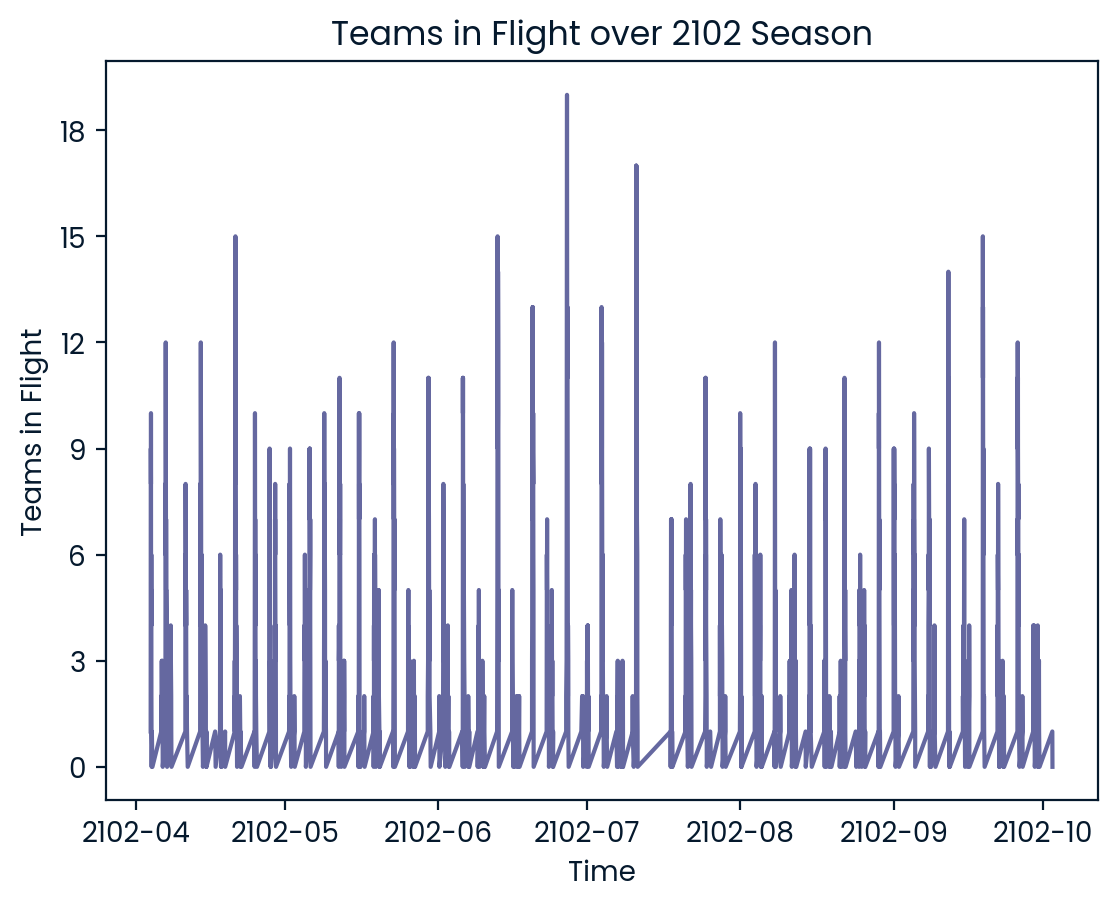

In [39]:
# Plotting
plt.plot(events['time'], events['in_flight'])
plt.xlabel("Time")
plt.ylabel("Teams in Flight")
plt.title("Teams in Flight over 2102 Season")

# make y-axis ticks to be whole numbers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

## **Question 2: Projecting and applying fuel costs**

**Breakdown:**

* We have daily fuel prices for 2101 (`fuel_price.csv`).
* Need to project them for 2102 → that’s a **time series forecasting task**.
* Each flight consumes **1 gallon per mile**. Distance is computed as:

  $$
  \text{distance} = (\text{flight duration in hours}) \times 500 \, \text{MPH}
  $$
* Fuel for each flight is purchased on the **departure date**, at that day’s projected price.

**Approach:**

1. Load `fuel_price.csv` (2101 data).
2. Fit a simple time series forecasting model to project daily fuel prices for 2102.
3. Merge the projected prices with `team_flights.csv` using departure date.
4. For each flight:

   * Compute distance = (landing – departure in hours) × 500.
   * Fuel used = distance (in gallons).
   * Cost = fuel used × projected price on departure date.
5. Sum all costs across all flights → store as `total_fuel_spend_2102_dollars`.

**Output:**

* Variable: `total_fuel_spend_2102_dollars`.
* (Optional) A visualization of projected fuel prices vs. actual 2101 prices.

**Business value:**
This forecast allows The League to **budget fuel costs** ahead of the 2102 season. It prevents surprises from price spikes and ensures enough funds are allocated to transportation.

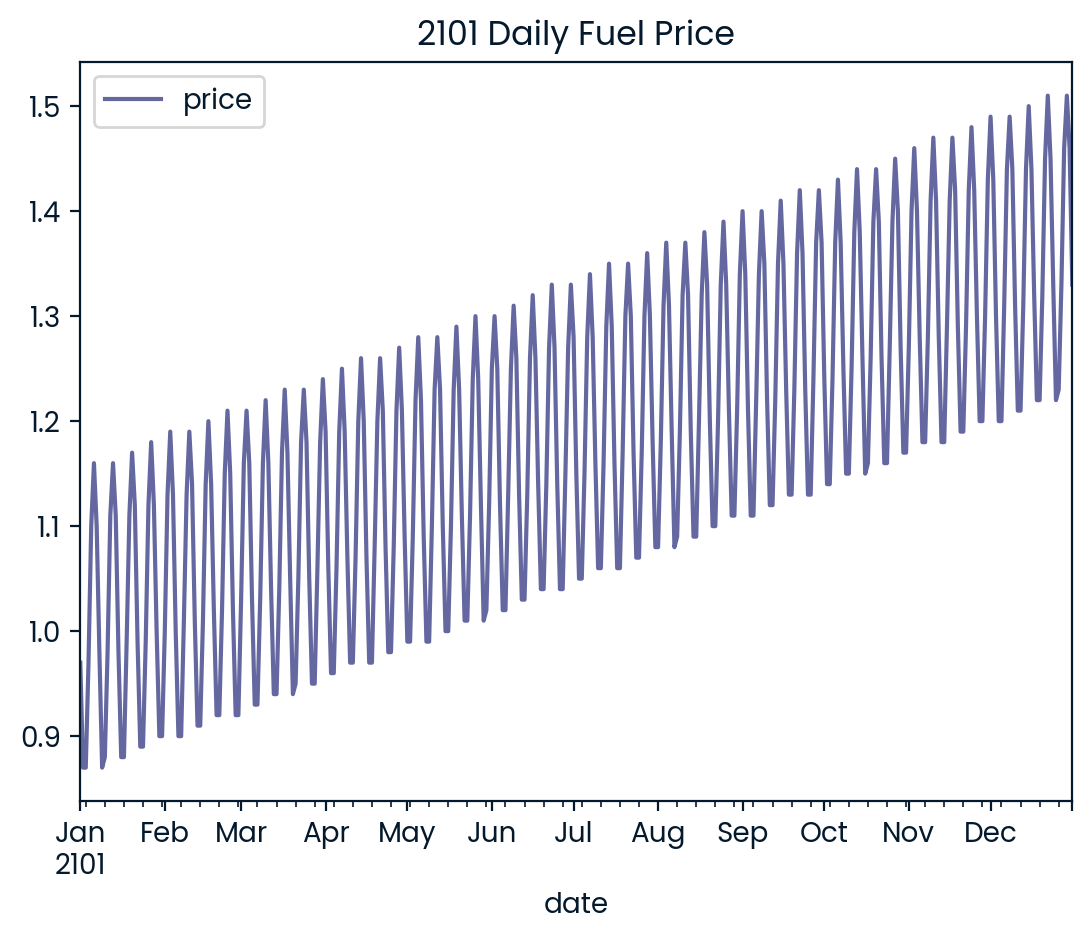

In [40]:
# Plotting fuel_price
fuel_prices.plot(title='2101 Daily Fuel Price')
plt.show()

In [41]:
# Stationary test
adf = adfuller(fuel_prices['price'].dropna())

print("ADF p-value:", adf[1])

ADF p-value: 0.9664205149823116


In [42]:
# First differencing to achieve stationarity
fuel_price_diff = fuel_prices['price'].diff().dropna()

adf_result = adfuller(fuel_price_diff)
print("ADF Statistic after first differencing:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic after first differencing: -6.519817570017749
p-value: 1.048987822874583e-08


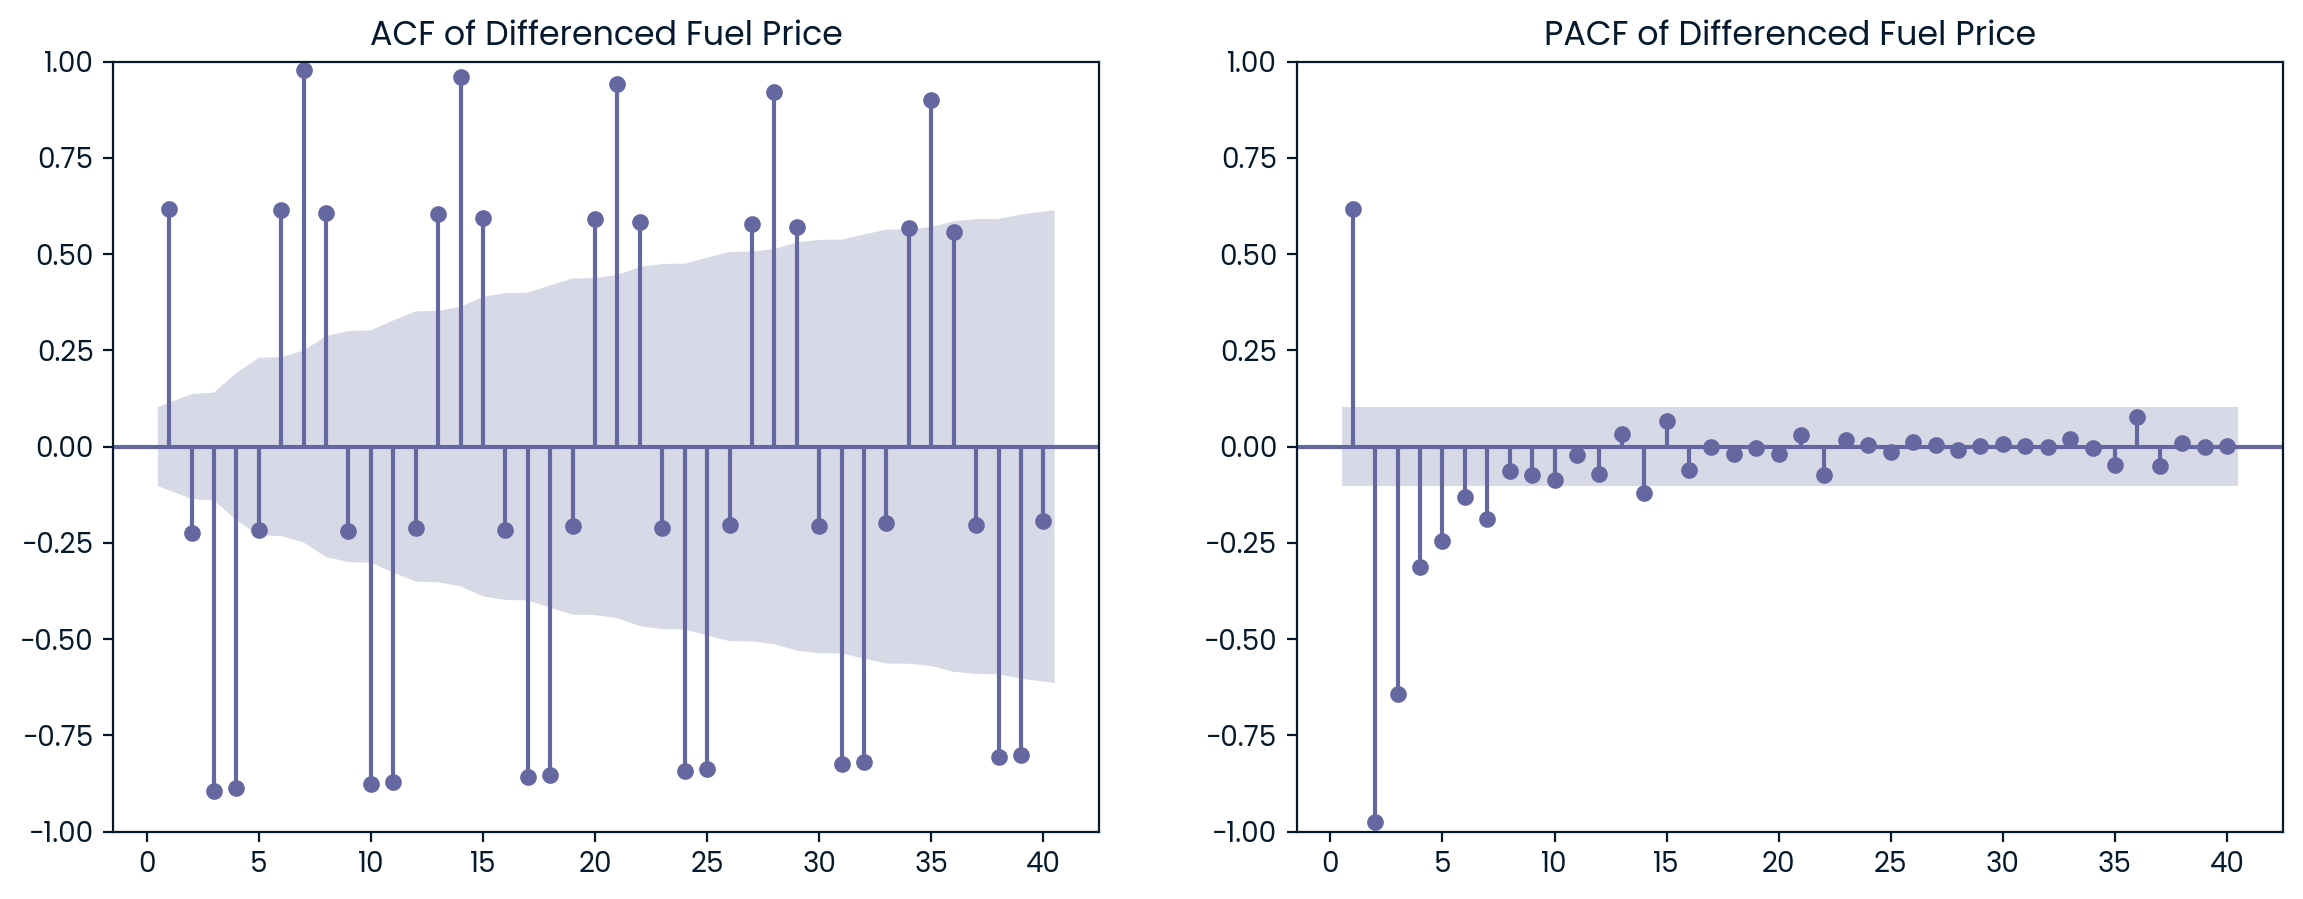

In [43]:
# Plot ACF and PACF for differenced fuel price
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(fuel_price_diff, lags=40, zero=False, ax=axes[0])
axes[0].set_title("ACF of Differenced Fuel Price")

plot_pacf(fuel_price_diff, lags=40, zero=False, ax=axes[1], method="ywm")
axes[1].set_title("PACF of Differenced Fuel Price")

plt.show()

**Summary:**

The ACF plot shows repeated spikes at lags 7, 14, 21, …, indicating a **weekly seasonal cycle** in fuel prices, while the PACF plot shows a strong spike at lag 1 and smaller ones up to lag 7, suggesting **short-term autoregressive effects**. 

From this, the non-seasonal terms are estimated as AR(1), differencing order d=1, and MA(1), giving (1,1,1). The seasonal pattern at multiples of 7 supports seasonal AR(1), seasonal differencing D=1, and seasonal MA(1) with a weekly period (s=7). 

Together, these observations suggest **SARIMA(1,1,1)(1,1,1,7)** as a strong initial candidate model.

In [44]:
# The Model
model_1 = SARIMAX(fuel_prices['price'],
                order=(1,1,1),           
                seasonal_order=(1,1,1,7) 
               )
results_1 = model_1.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.00131D+00    |proj g|=  9.50064D+01

At iterate    5    f= -4.09552D+00    |proj g|=  3.04851D-01

At iterate   10    f= -4.09622D+00    |proj g|=  1.21350D+01

At iterate   15    f= -4.16112D+00    |proj g|=  5.63308D+01

At iterate   20    f= -4.17587D+00    |proj g|=  1.23956D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     43      1     0     0   4.061D-01  -4.176D+00
  F =  -4.1759252309876977     

CONVERG

In [45]:
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             price   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1524.213
Date:                           Sat, 27 Sep 2025   AIC                          -3038.425
Time:                                   16:19:58   BIC                          -3019.037
Sample:                               01-01-2101   HQIC                         -3030.714
                                    - 12-31-2101                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3857      0.075     -5.149      0.000      -0.532      -0.239
ma.L1         -0.7605      0.049    -15.635      0.000      -0.856      -0.665
ar.S.L7       -0.3963      0.069     -5.766      0.000      -0.531      -0.262
ma.S.L7       -0.8123      0.088     -9.260      0.000      -0.984      -0.640
sigma2      1.098e-05   1.46e-06      7.513      0.000    8.12e-06    1.38e-05
===================================================================================
Ljung-Box (L1) (Q):                  13.10   Jarque-Bera (JB):                20.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.44
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

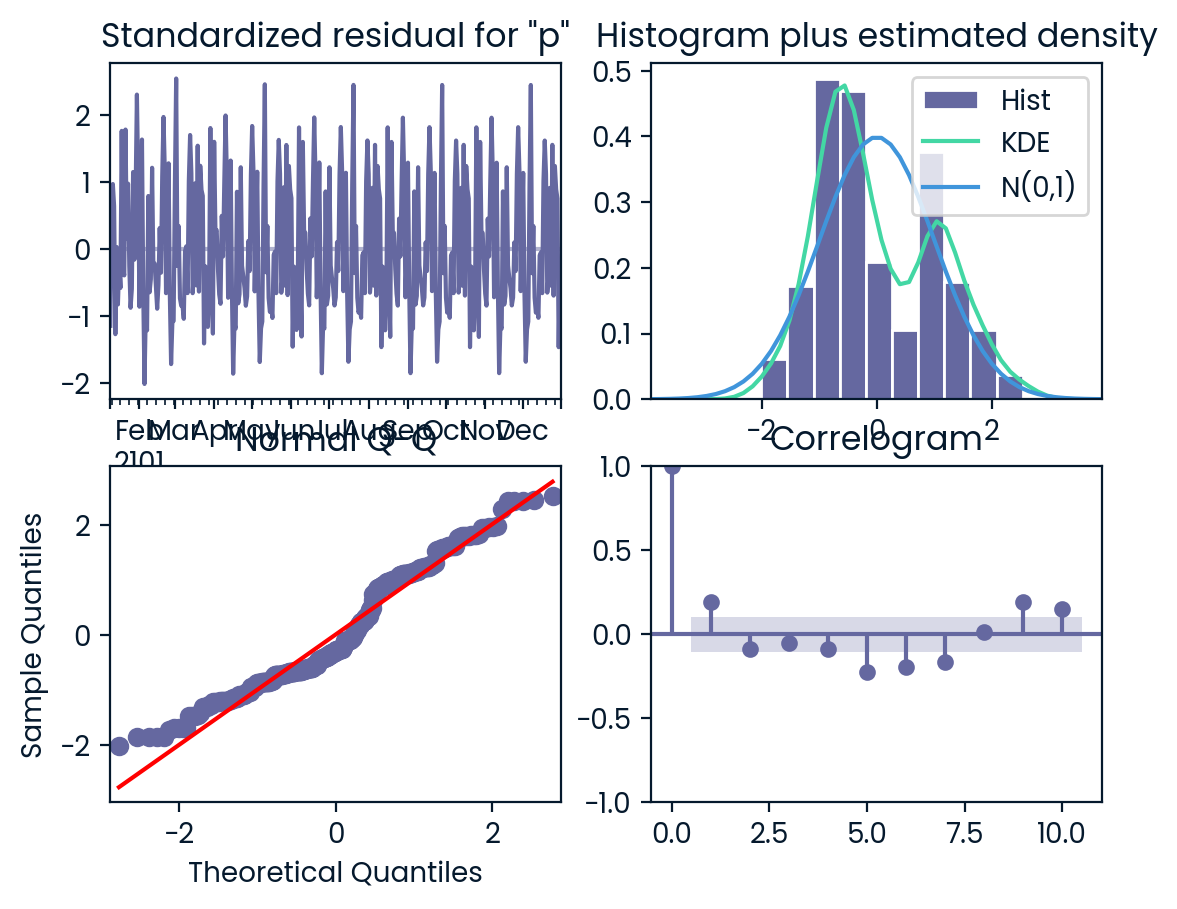

In [46]:
results_1.plot_diagnostics()
plt.show()

**Interpretation**

The model:

- Captures short-term effects (AR and MA).

- Captures weekly seasonality well (seasonal AR and MA both significant).

- Fits data strongly (low AIC/BIC).

- Residuals aren’t perfectly clean (Ljung-Box shows some autocorrelation), but overall the model is a good candidate.

In [47]:
# Forecasting for the 2102 season
forecast_steps = 365
forecast_2102 = results_1.get_forecast(steps=forecast_steps)

# Extract predictions and confidence intervals
forecast_mean_2102 = forecast_2102.predicted_mean
forecast_ci_2102 = forecast_2102.conf_int()

In [48]:
fuel_prices.index = fuel_prices.index.to_timestamp()
forecast_mean_2102.index = forecast_mean_2102.index.to_timestamp()
forecast_ci_2102.index = forecast_ci_2102.index.to_timestamp()

In [49]:
forecast_mean_2102.head()

2102-01-01    1.234011
2102-01-02    1.231428
2102-01-03    1.334893
2102-01-04    1.463351
2102-01-05    1.523378
Freq: D, Name: predicted_mean, dtype: float64

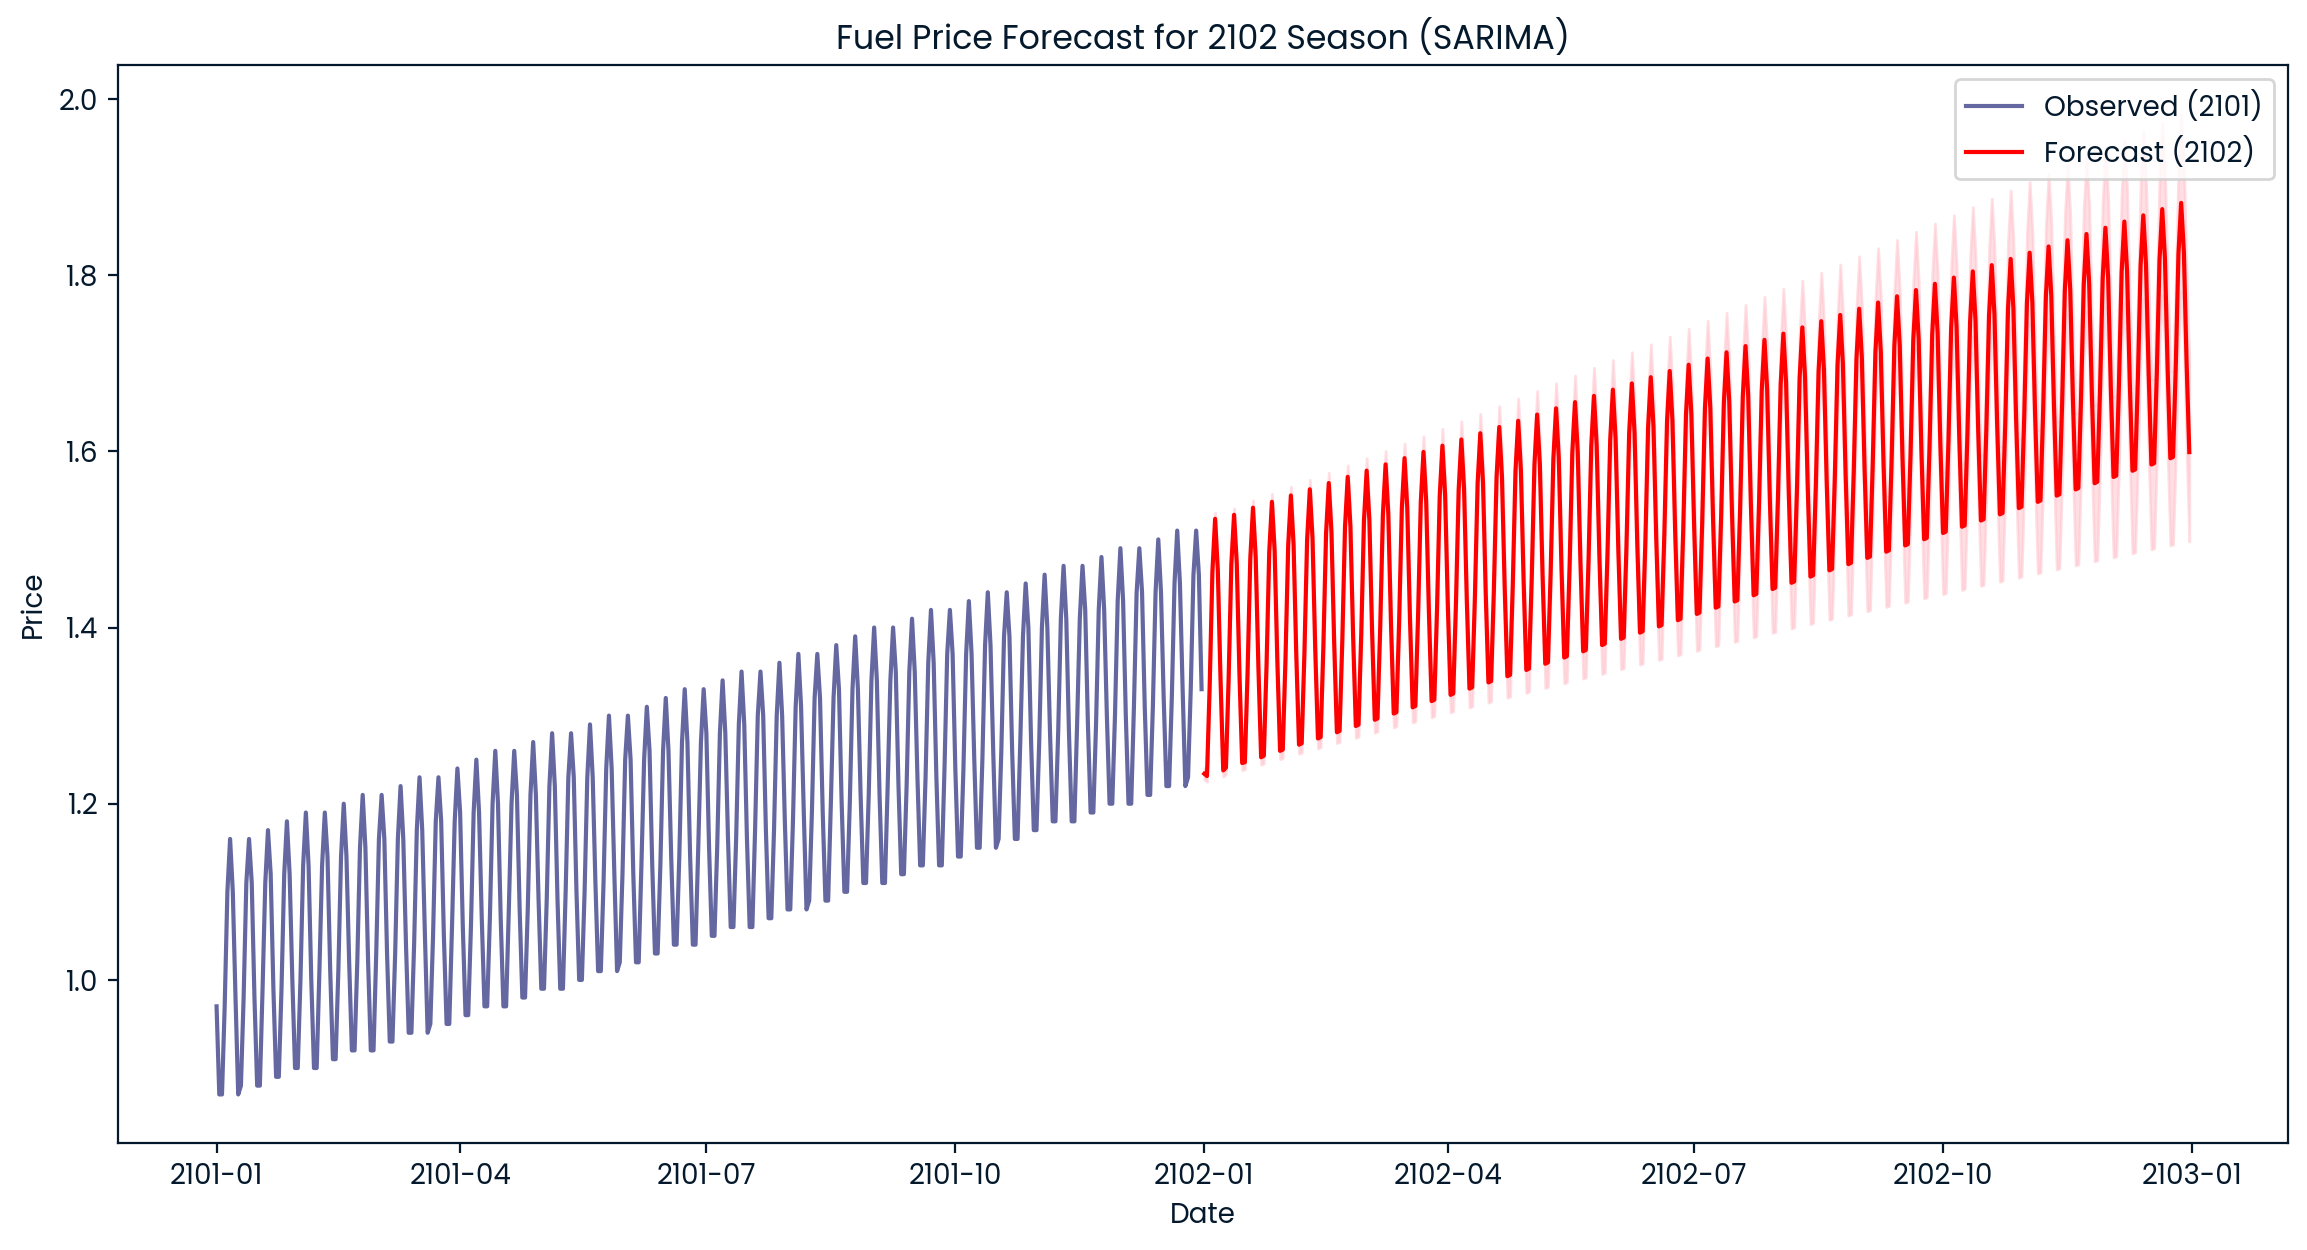

In [50]:
plt.figure(figsize=(14,7))

# Plot observed data (2101)
plt.plot(fuel_prices['price'], label="Observed (2101)")

# Forecast (2102)
plt.plot(forecast_mean_2102.index, forecast_mean_2102, color="red", label="Forecast (2102)")

# Confidence intervals
plt.fill_between(
    forecast_ci_2102.index,
    forecast_ci_2102.iloc[:,0],
    forecast_ci_2102.iloc[:,1],
    color="pink", alpha=0.5
)

plt.title("Fuel Price Forecast for 2102 Season (SARIMA)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [51]:
# Obtaining departute date
team_flights['departure_date'] = team_flights['departure_datetime'].dt.date

In [52]:
# Extracting and restructing forecasted data
forecast_prices = forecast_mean_2102.reset_index()
forecast_prices.columns = ['date', 'forecast_price']
forecast_prices['date'] = forecast_prices['date'].dt.date

In [53]:
forecast_prices.head()

,date,forecast_price
0,2102-01-01,1.234011
1,2102-01-02,1.231428
2,2102-01-03,1.334893
3,2102-01-04,1.463351
4,2102-01-05,1.523378


In [54]:
# merging flights and forecasted prices
flights_with_price = pd.merge(
    team_flights,
    forecast_prices,
    left_on='departure_date',
    right_on='date',
    how='left'
)

In [55]:
# compute fuel cost per flight - 1 gallon = 1 mile
flights_with_price['fuel_cost'] = flights_with_price['travel_distance_miles'] * flights_with_price['forecast_price']

In [56]:
flights_with_price.sample(5)

,team_name,departure_datetime,landing_datetime,travel_distance_miles,departure_date,date,forecast_price,fuel_cost
90,Cunning Cougars,2102-06-07 00:40:00,2102-06-07 01:45:39,547.083333,2102-06-07,2102-06-07,1.619892,886.216044
391,Knightly Kangaroos,2102-05-12 00:45:00,2102-05-12 04:12:45,1731.250000,2102-05-12,2102-05-12,1.592639,2757.255685
574,Proud Panthers,2102-04-14 00:20:00,2102-04-14 00:55:53,299.027778,2102-04-14,2102-04-14,1.564372,467.790780
663,Rapid Rabbits,2102-06-05 22:39:00,2102-06-05 23:58:42,664.166667,2102-06-05,2102-06-05,1.388638,922.287377
898,Xenial Xerus,2102-07-08 03:27:00,2102-07-08 03:51:26,203.611111,2102-07-08,2102-07-08,1.523780,310.258456


In [57]:
# total forecasted fuel cost
total_fuel_spend_2102_dollars = flights_with_price['fuel_cost'].sum()

total_fuel_spend_2102_dollars

1870355.051901118